In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Pg 145
df = pd.read_csv('../data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


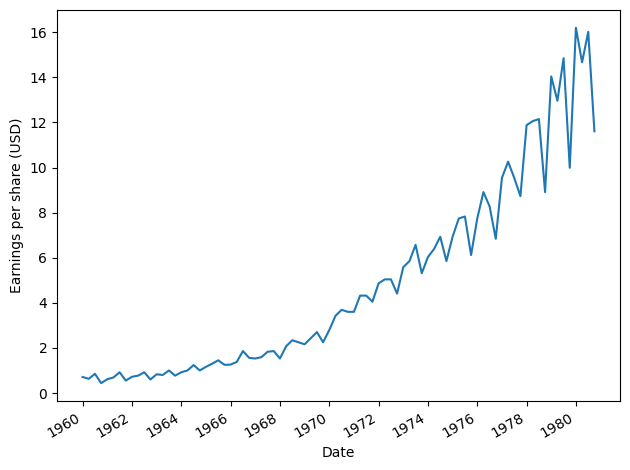

In [3]:
# Figure 7.5 in pg 147

fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH07_F02_peixeiro.png', dpi=300)

In [4]:
# Pg 147
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# It shows non-stationarity

# Impact of differencing
std_0 = df['data'].std()
print(f'Standard deviation of raw series is {std_0}')

ADF Statistic: 2.7420165734574806
p-value: 1.0
Standard deviation of raw series is 4.309991176824922


In [5]:
# Pg 147
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# Afteer first-order differencing, it still shows non-stationarity

# Impact of differencing
std_1 = eps_diff.std()
print(f'Standard deviation of first-order differencing series is {std_1}')

ADF Statistic: -0.4074097636380464
p-value: 0.9088542416911305
Standard deviation of first-order differencing series is 1.416000485573012


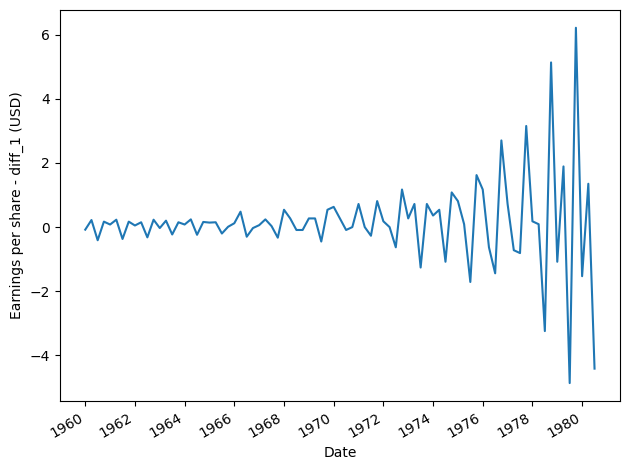

In [6]:
# This figure is not in the book

fig, ax = plt.subplots()

ax.plot(df['date'][1:], eps_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff_1 (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
# Pg 148

eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# Afteer second-order differencing, then it shows stationarity

# Impact of differencing
std_2 = eps_diff2.std()
print(f'Standard deviation of second-order differencing series is {std_2}')

ADF Statistic: -3.585162874793206
p-value: 0.006051099869602666
Standard deviation of second-order differencing series is 2.4547094528732023


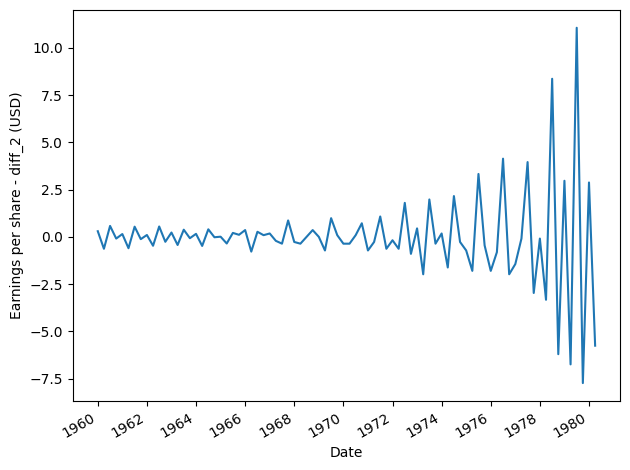

In [8]:
# This figure is not in the book

fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff_2 (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH07_F01_peixeiro.png', dpi=300)

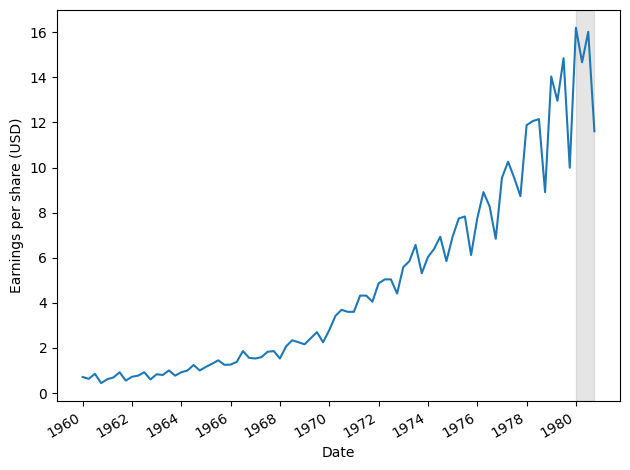

In [9]:
# Figure 7.6 in pg 148

fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH07_F06_peixeiro.png', dpi=300)

In [10]:
# Pg 149

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
# Pg 149

ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [12]:
# Pg 150

train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.278829
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430633
4,"(0, 3)",194.654716
5,"(0, 2)",209.274659
6,"(2, 3)",220.666881
7,"(1, 3)",228.267743
8,"(1, 2)",228.935873
9,"(2, 2)",229.974680


In [13]:
# Pg 150

model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)
# Not in the book
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.639
Date:                Sat, 07 Feb 2026   AIC                            115.279
Time:                        20:19:16   BIC                            131.776
Sample:                             0   HQIC                           121.883
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9999      0.037    -27.057      0.000      -1.072      -0.927
ar.L2         -0.9870      0.040    -24.470      0.000      -1.066      -0.908
ar.L3         -0.9746      0.027    -36.264      0.0

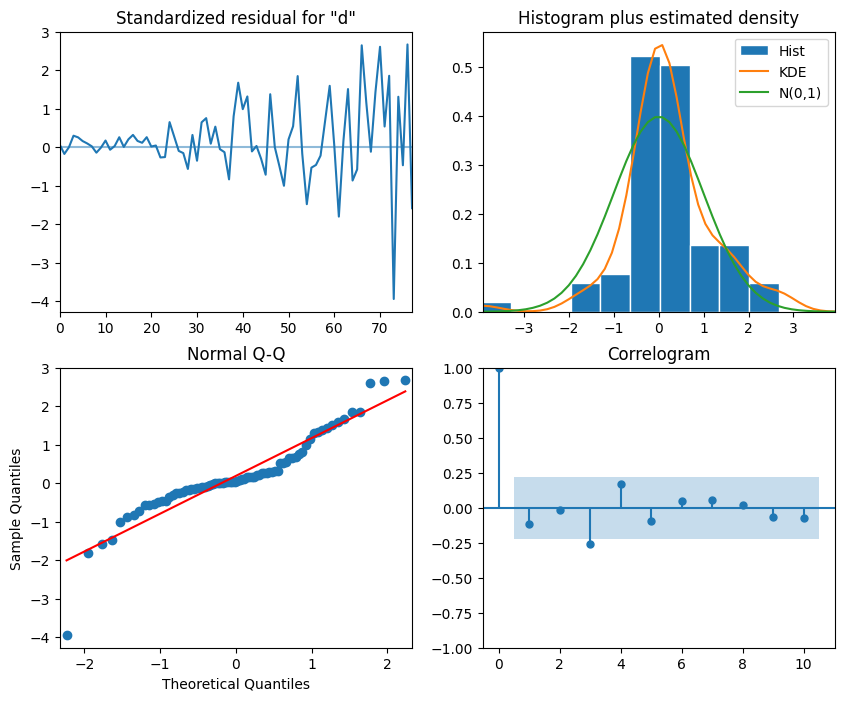

In [14]:
# Figure 7.7 in pg 151

model_fit.plot_diagnostics(figsize=(10,8))

plt.savefig('figures/CH07_F07_peixeiro.png', dpi=300)

In [15]:
# residuals = model_fit.resid

# lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# print(pvalue)

In [16]:
# Pg 151

residuals = model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,1.664364,0.197015
2,1.666019,0.434739
3,7.330313,0.062083
4,9.307973,0.053846
5,9.923169,0.077442
6,10.147149,0.118590
7,10.385066,0.167782
8,10.422536,0.236612
9,10.756776,0.292750
10,11.218090,0.340781


In [17]:
# Pg 152

test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [ ]:
# Pg 152

ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

80    15.857798
81    14.375961
82    16.367278
83    11.685142
84    17.410309
85    15.931343
86    17.887230
87    13.376688
88    18.962453
Name: predicted_mean, dtype: float64

In [ ]:
# Figure 7.8 in pg 152

fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH07_F08_peixeiro.png', dpi=300)

In [ ]:
# Pg 153
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Pg 153
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

In [ ]:
# Figure 7.9 in pg 153

fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH07_F09_peixeiro.png', dpi=300)

The forecasts are 1.73% off from the actual values

**************************************************************************************
#### Extra ---> Returns + Differencing

To make it stationary, obtaining returns instead of differencing

In [ ]:
returns = df['data'].pct_change().dropna() 

ad_fuller_result = adfuller(returns)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# After first-order returns, it still shows non-stationarity

# Impact of obtaining returns
std_1 = returns.std()
print(f'Standard deviation of first-order returns series is {std_1}, from 4.3 of the raw series')

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['date'][1:], returns)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - returns (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

To make it stationary, after obtaining returns, now differencing

In [ ]:
eps_diff_returns = np.diff(returns, n=1)

ad_fuller_result = adfuller(eps_diff_returns)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# After obtaining returns and then first-order differencing, now it shows stationarity

# Impact of differencing after obtaining returns
std_2 = eps_diff_returns.std()
print(f'Standard deviation of first-order differencing of the returns is {std_2}, from 0.21 of the returns')

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff_returns)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - difference of returns (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

**************************************************************************************
#### Extra ---> Log of EPS + Differencing

To make it stationary, obtaining log instead of differencing

In [ ]:
log_EPS = np.log(df['data'])
ad_fuller_result = adfuller(log_EPS)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# After log of EPS, it still shows non-stationarity

# Impact of obtaining log of EPS
std_1 = log_EPS.std()
print(f'Standard deviation of log of EPS is {std_1}, from 4.3 of the raw series')

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['date'][0:], log_EPS)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - returns (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

To make it stationary, after obtaining log, now differencing

In [ ]:
log_returns = np.log(df['data']).diff().dropna() 

ad_fuller_result = adfuller(log_returns)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# After first-order differencing log of EPS, it shows stationarity

# Impact of differencing log of EPS
std_1 = log_returns.std()
print(f'Standard deviation of first-order differencing of log of EPS is {std_1}, from 1.0 of the logs')

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['date'][1:], log_returns)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - returns (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()